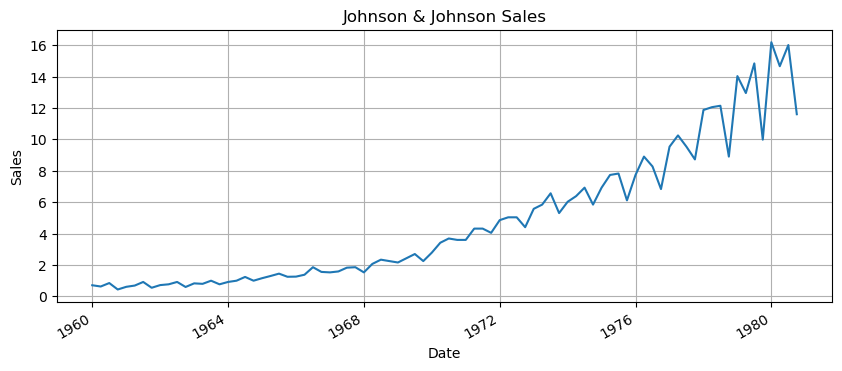

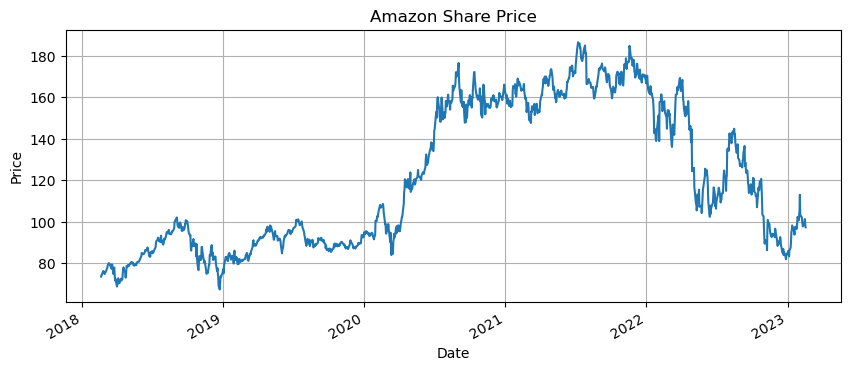

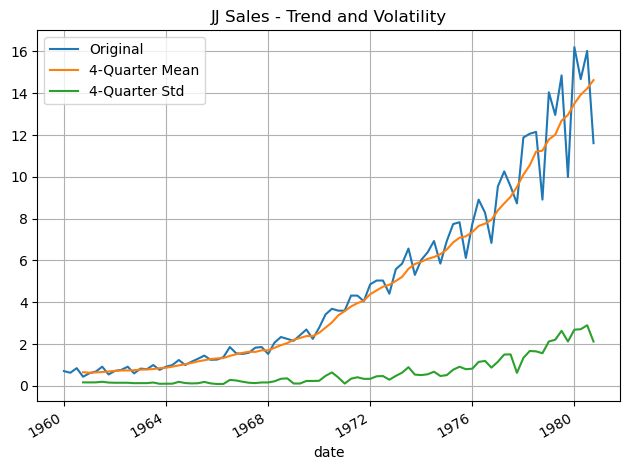

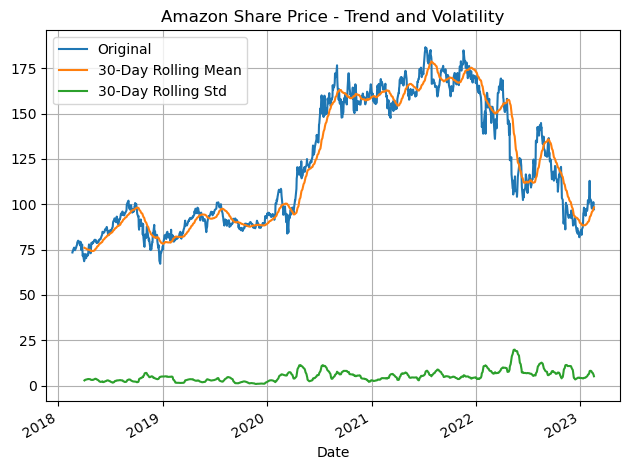

JJ Original ADF p-value = 1.0 --> Non-Stationary
JJ Log-Differenced ADF p-value = 0.00041497314044406503 --> Stationary
AMZN Original ADF p-value = 0.45297105465166737 --> Non-Stationary
AMZN Log-Differenced ADF p-value = 0.0 --> Stationary


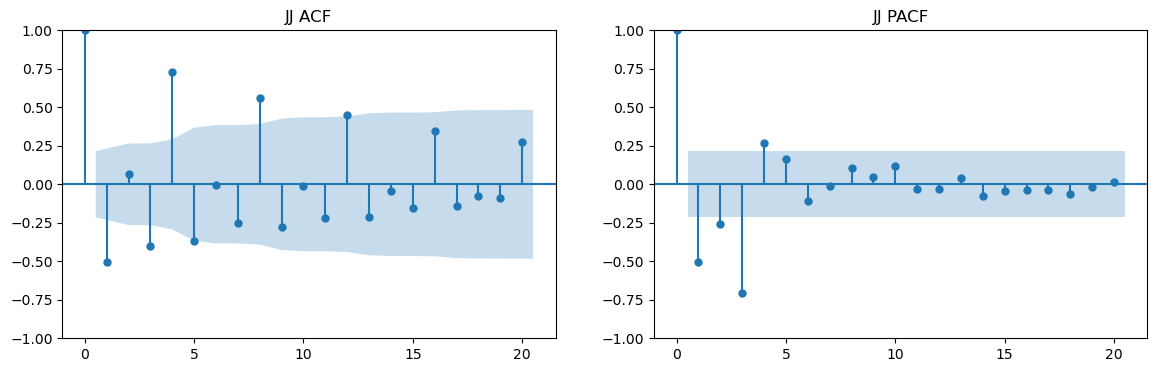

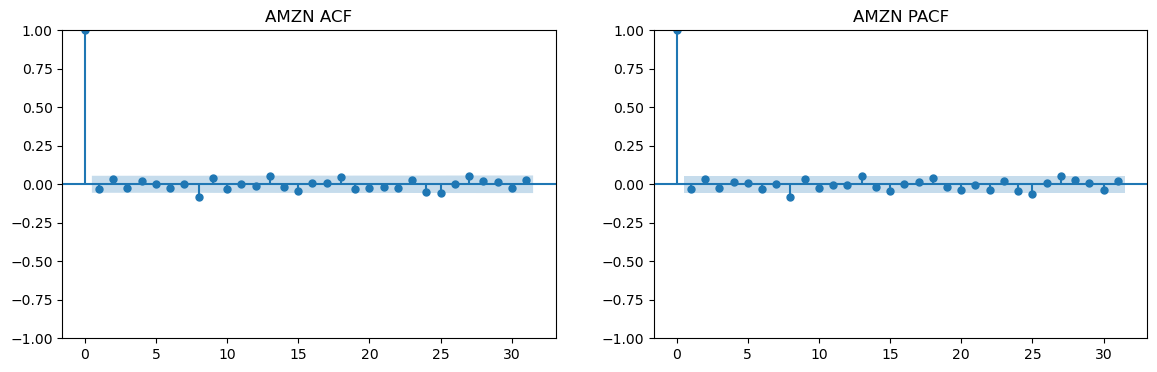

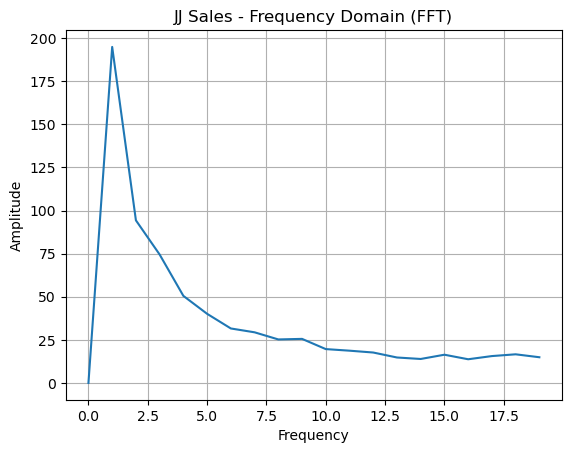

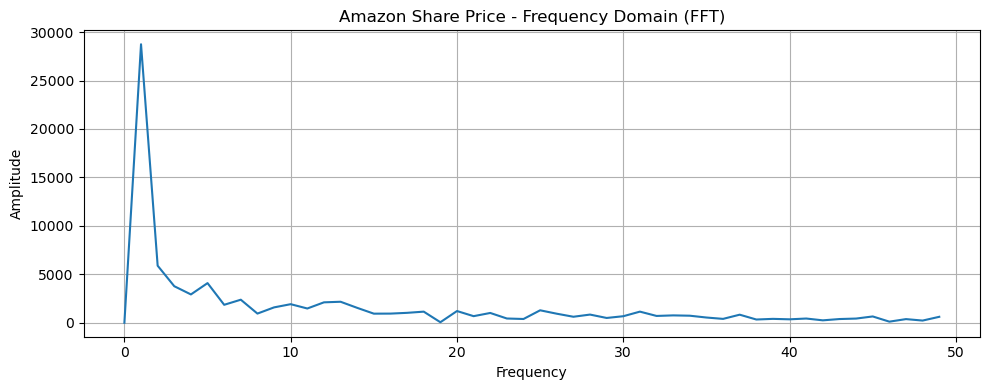

Best ARMA order: (3, 0, 2) with AIC=-151.14960396420193
Best ARMA order: (0, 0, 0) with AIC=-5938.460589351041


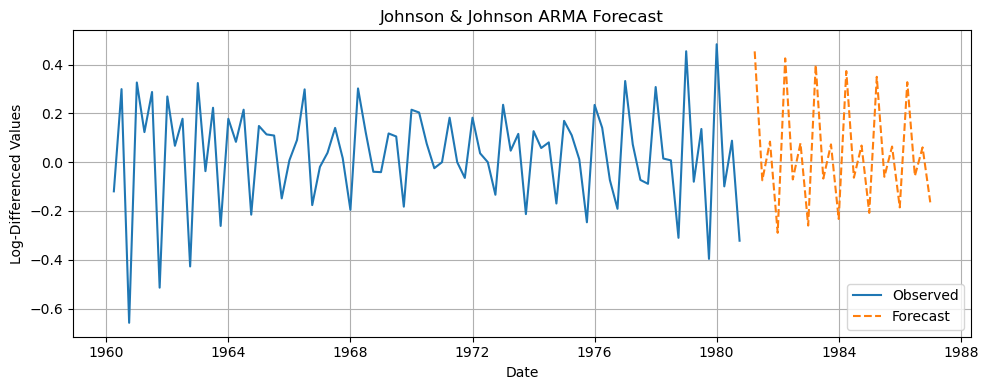

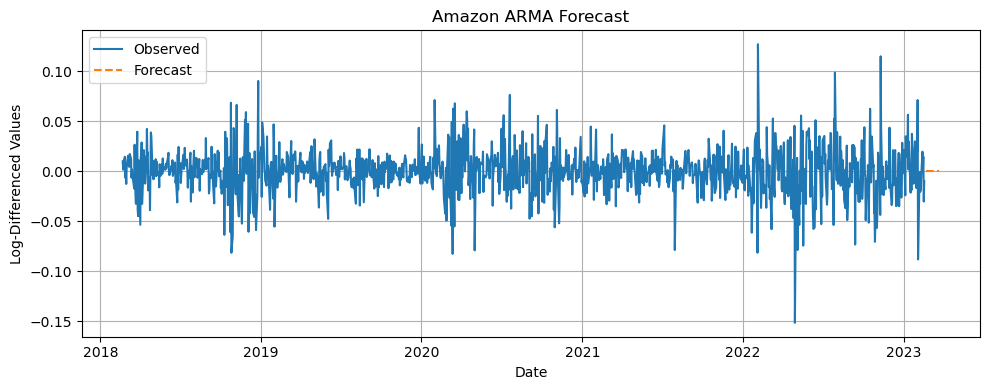

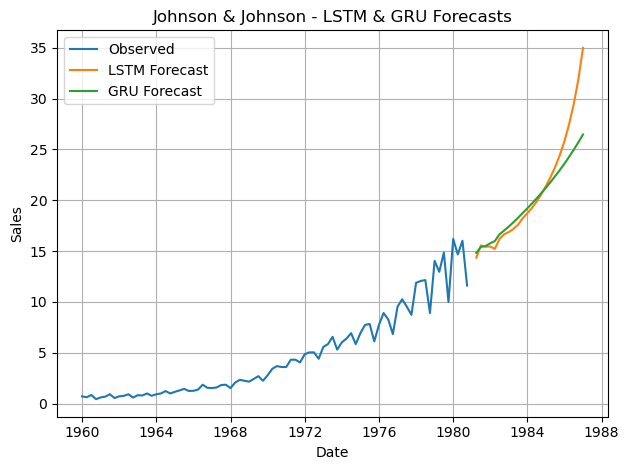

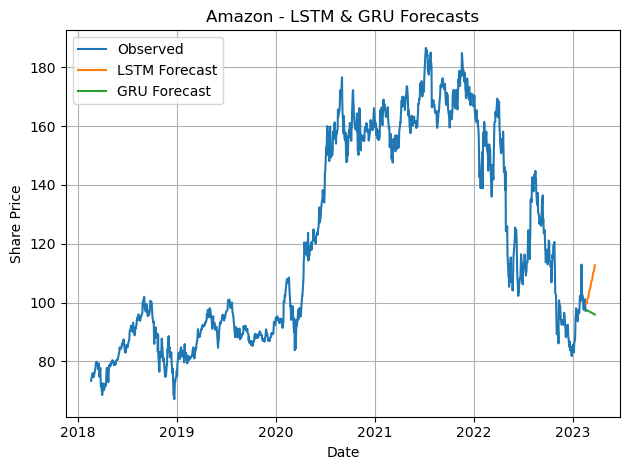

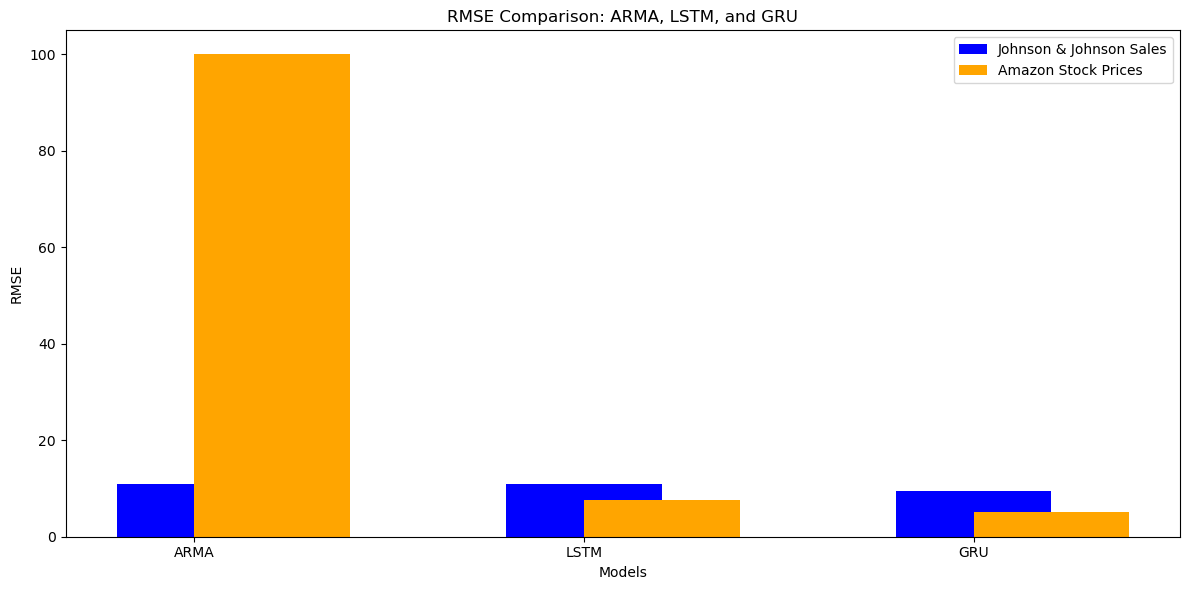

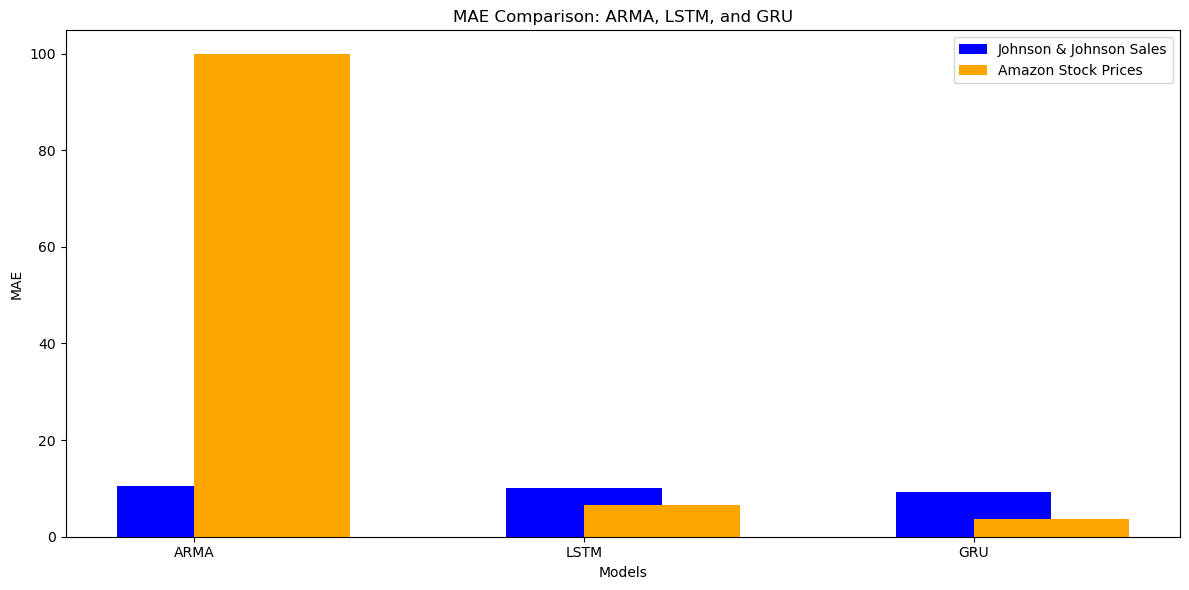

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from itertools import product
from scipy.fft import fft
from pandas.tseries.offsets import DateOffset
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
from sklearn.preprocessing import MinMaxScaler


# 1. Load and prepare the data

jj_data = pd.read_csv('/Users/user1/Downloads/jj.csv')
amzn_data = pd.read_csv('/Users/user1/Downloads/AMZN.csv')

jj_data['date'] = pd.to_datetime(jj_data['date'])
jj_data.set_index('date', inplace=True)
jj_data.rename(columns={'data': 'Sales'}, inplace=True)

amzn_data['Date'] = pd.to_datetime(amzn_data['Date'])
amzn_data.set_index('Date', inplace=True)


# 2. Visualize the Time Series

jj_data['Sales'].plot(title='Johnson & Johnson Sales', figsize=(10, 4))
plt.xlabel('Date'); plt.ylabel('Sales'); plt.grid(True); plt.show()

amzn_data['Close'].plot(title='Amazon Share Price', figsize=(10, 4))
plt.xlabel('Date'); plt.ylabel('Price'); plt.grid(True); plt.show()

# JJ Trend & Volatility
jj_data['Sales'].plot(label='Original')
jj_data['Sales'].rolling(window=4).mean().plot(label='4-Quarter Mean')
jj_data['Sales'].rolling(window=4).std().plot(label='4-Quarter Std')
plt.legend(); plt.title('JJ Sales - Trend and Volatility'); plt.grid(True); plt.tight_layout(); plt.show()

# AMZN Trend & Volatility
amzn_data['Close'].plot(label='Original')
amzn_data['Close'].rolling(window=30).mean().plot(label='30-Day Rolling Mean')
amzn_data['Close'].rolling(window=30).std().plot(label='30-Day Rolling Std')
plt.legend(); plt.title('Amazon Share Price - Trend and Volatility'); plt.grid(True); plt.tight_layout(); plt.show()


# 3. ADF Stationarity Testing

def adf_test(series, title=''):
    result = adfuller(series.dropna(), autolag='AIC')
    print(f'{title} ADF p-value = {result[1]} -->', 'Stationary' if result[1] < 0.05 else 'Non-Stationary')

jj_log = np.log(jj_data['Sales'])
jj_diff = jj_log.diff().dropna()

amzn_log = np.log(amzn_data['Close'])
amzn_diff = amzn_log.diff().dropna()

adf_test(jj_data['Sales'], 'JJ Original')
adf_test(jj_diff, 'JJ Log-Differenced')
adf_test(amzn_data['Close'], 'AMZN Original')
adf_test(amzn_diff, 'AMZN Log-Differenced')


# 4. ACF and PACF Plots

fig, ax = plt.subplots(1, 2, figsize=(14, 4))
plot_acf(jj_diff, ax=ax[0]); plot_pacf(jj_diff, ax=ax[1])
ax[0].set_title('JJ ACF'); ax[1].set_title('JJ PACF'); plt.show()

fig, ax = plt.subplots(1, 2, figsize=(14, 4))
plot_acf(amzn_diff, ax=ax[0]); plot_pacf(amzn_diff, ax=ax[1])
ax[0].set_title('AMZN ACF'); ax[1].set_title('AMZN PACF'); plt.show()


# 5. FFT Spectral Analysis

jj_sales_array = jj_data['Sales'].values.astype(float)
jj_fft = np.abs(fft(jj_sales_array - np.mean(jj_sales_array)))
plt.plot(jj_fft[:20]); plt.title('JJ Sales - Frequency Domain (FFT)')
plt.xlabel('Frequency'); plt.ylabel('Amplitude'); plt.grid(True); plt.show()

amzn_array = amzn_data['Close'].values.astype(float)
amzn_fft = np.abs(fft(amzn_array - np.mean(amzn_array)))
plt.figure(figsize=(10, 4))
plt.plot(amzn_fft[:50])
plt.title('Amazon Share Price - Frequency Domain (FFT)')
plt.xlabel('Frequency'); plt.ylabel('Amplitude')
plt.grid(True); plt.tight_layout(); plt.show()


# 6. ARMA Modeling (ARIMA with d=0)

def find_best_arma(data, p_range, q_range):
    best_aic = np.inf; best_order = None
    for p, q in product(p_range, q_range):
        try:
            model = ARIMA(data, order=(p, 0, q)).fit()
            if model.aic < best_aic:
                best_aic = model.aic
                best_order = (p, 0, q)
        except:
            continue
    print(f'Best ARMA order: {best_order} with AIC={best_aic}')
    return best_order

jj_order = find_best_arma(jj_diff, range(0, 4), range(0, 4))
amzn_order = find_best_arma(amzn_diff, range(0, 4), range(0, 4))


# 7. ARMA Forecasting

def plot_arma_forecast(data_log, order, label, steps=24):
    model = ARIMA(data_log, order=order).fit()
    forecast = model.forecast(steps=steps)

    last_date = data_log.index[-1]
    forecast_index = pd.date_range(start=last_date + pd.DateOffset(months=3), periods=steps, freq='Q') \
        if len(data_log) < 100 else pd.date_range(start=last_date + pd.Timedelta(days=1), periods=steps, freq='B')
    forecast.index = forecast_index

    plt.figure(figsize=(10, 4))
    plt.plot(data_log, label='Observed')
    plt.plot(forecast, label='Forecast', linestyle='--')
    plt.title(f'{label} ARMA Forecast')
    plt.xlabel('Date'); plt.ylabel('Log-Differenced Values'); plt.grid(True)
    plt.legend(); plt.tight_layout(); plt.show()
    return model, forecast

jj_model, jj_forecast = plot_arma_forecast(jj_diff, jj_order, 'Johnson & Johnson')
amzn_model, amzn_forecast = plot_arma_forecast(amzn_diff, amzn_order, 'Amazon')


# 8. Deep Learning: LSTM & GRU

def create_sequences(data, n_steps=5):
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data[i-n_steps:i])
        y.append(data[i])
    return np.array(X), np.array(y)

def build_model(model_type, input_shape):
    model = Sequential()
    if model_type == 'LSTM':
        model.add(LSTM(50, activation='relu', input_shape=input_shape))
    elif model_type == 'GRU':
        model.add(GRU(50, activation='relu', input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

def recursive_forecast(model, last_seq, steps=24):
    forecast = []
    current_seq = last_seq.copy()
    for _ in range(steps):
        pred = model.predict(current_seq.reshape(1, current_seq.shape[0], 1), verbose=0)
        forecast.append(pred[0,0])
        current_seq = np.append(current_seq[1:], pred).reshape(-1, 1)
    return np.array(forecast)
    

# JJ LSTM & GRU

scaler_jj = MinMaxScaler()
jj_scaled = scaler_jj.fit_transform(jj_data['Sales'].values.reshape(-1, 1))
X_jj, y_jj = create_sequences(jj_scaled, n_steps=5)
X_jj = X_jj.reshape((X_jj.shape[0], X_jj.shape[1], 1))

lstm_jj = build_model('LSTM', (X_jj.shape[1], 1))
lstm_jj.fit(X_jj, y_jj, epochs=50, verbose=0)
forecast_lstm_jj = scaler_jj.inverse_transform(recursive_forecast(lstm_jj, jj_scaled[-5:]).reshape(-1, 1))

gru_jj = build_model('GRU', (X_jj.shape[1], 1))
gru_jj.fit(X_jj, y_jj, epochs=50, verbose=0)
forecast_gru_jj = scaler_jj.inverse_transform(recursive_forecast(gru_jj, jj_scaled[-5:]).reshape(-1, 1))

plt.plot(jj_data['Sales'], label='Observed')
plt.plot(pd.date_range(jj_data.index[-1], periods=25, freq='Q')[1:], forecast_lstm_jj, label='LSTM Forecast')
plt.plot(pd.date_range(jj_data.index[-1], periods=25, freq='Q')[1:], forecast_gru_jj, label='GRU Forecast')
plt.title('Johnson & Johnson - LSTM & GRU Forecasts')
plt.xlabel('Date'); plt.ylabel('Sales'); plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

# AMZN LSTM & GRU
scaler_amzn = MinMaxScaler()
amzn_scaled = scaler_amzn.fit_transform(amzn_data['Close'].values.reshape(-1, 1))
X_amzn, y_amzn = create_sequences(amzn_scaled, n_steps=5)
X_amzn = X_amzn.reshape((X_amzn.shape[0], X_amzn.shape[1], 1))

lstm_amzn = build_model('LSTM', (X_amzn.shape[1], 1))
lstm_amzn.fit(X_amzn, y_amzn, epochs=50, verbose=0)
forecast_lstm_amzn = scaler_amzn.inverse_transform(recursive_forecast(lstm_amzn, amzn_scaled[-5:]).reshape(-1, 1))

gru_amzn = build_model('GRU', (X_amzn.shape[1], 1))
gru_amzn.fit(X_amzn, y_amzn, epochs=50, verbose=0)
forecast_gru_amzn = scaler_amzn.inverse_transform(recursive_forecast(gru_amzn, amzn_scaled[-5:]).reshape(-1, 1))

plt.plot(amzn_data['Close'], label='Observed')
plt.plot(pd.date_range(amzn_data.index[-1], periods=25, freq='B')[1:], forecast_lstm_amzn, label='LSTM Forecast')
plt.plot(pd.date_range(amzn_data.index[-1], periods=25, freq='B')[1:], forecast_gru_amzn, label='GRU Forecast')
plt.title('Amazon - LSTM & GRU Forecasts')
plt.xlabel('Date'); plt.ylabel('Share Price'); plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()


# 9. RMSE and MAE Computation for ARMA, LSTM, and GRU

# Function to compute RMSE and MAE
def compute_rmse_mae(observed, forecast):
    rmse = np.sqrt(mean_squared_error(observed, forecast))
    mae = mean_absolute_error(observed, forecast)
    return rmse, mae

# ARMA Forecasts for JJ Sales and AMZN Prices
arma_rmse_jj, arma_mae_jj = compute_rmse_mae(jj_data['Sales'].iloc[-len(jj_forecast):], jj_forecast)
arma_rmse_amzn, arma_mae_amzn = compute_rmse_mae(amzn_data['Close'].iloc[-len(amzn_forecast):], amzn_forecast)

# LSTM and GRU Forecasts for JJ Sales
lstm_rmse_jj, lstm_mae_jj = compute_rmse_mae(jj_data['Sales'].iloc[-len(forecast_lstm_jj):], forecast_lstm_jj)
gru_rmse_jj, gru_mae_jj = compute_rmse_mae(jj_data['Sales'].iloc[-len(forecast_gru_jj):], forecast_gru_jj)

# LSTM and GRU Forecasts for AMZN Prices
lstm_rmse_amzn, lstm_mae_amzn = compute_rmse_mae(amzn_data['Close'].iloc[-len(forecast_lstm_amzn):], forecast_lstm_amzn)
gru_rmse_amzn, gru_mae_amzn = compute_rmse_mae(amzn_data['Close'].iloc[-len(forecast_gru_amzn):], forecast_gru_amzn)

# 10. Plot RMSE and MAE Comparison (Bar Plot)

# RMSE Comparison Bar Plot
labels = ['ARMA', 'LSTM', 'GRU']
jj_rmse = [arma_rmse_jj, lstm_rmse_jj, gru_rmse_jj]
amzn_rmse = [arma_rmse_amzn, lstm_rmse_amzn, gru_rmse_amzn]

plt.figure(figsize=(12, 6))
plt.bar(labels, jj_rmse, width=0.4, label='Johnson & Johnson Sales', align='center', color='blue')
plt.bar(labels, amzn_rmse, width=0.4, label='Amazon Stock Prices', align='edge', color='orange')
plt.title('RMSE Comparison: ARMA, LSTM, and GRU')
plt.xlabel('Models')
plt.ylabel('RMSE')
plt.legend()
plt.tight_layout()
plt.show()

# MAE Comparison Bar Plot
jj_mae = [arma_mae_jj, lstm_mae_jj, gru_mae_jj]
amzn_mae = [arma_mae_amzn, lstm_mae_amzn, gru_mae_amzn]

plt.figure(figsize=(12, 6))
plt.bar(labels, jj_mae, width=0.4, label='Johnson & Johnson Sales', align='center', color='blue')
plt.bar(labels, amzn_mae, width=0.4, label='Amazon Stock Prices', align='edge', color='orange')
plt.title('MAE Comparison: ARMA, LSTM, and GRU')
plt.xlabel('Models')
plt.ylabel('MAE')
plt.legend()
plt.tight_layout()
plt.show()


In [4]:
!pip install tensorflow
